# HOPUS

HOPUS (**HO**using **P**ricing **U**tilitie**S**) contains a variety of routines used to predict real estate prices.

This notebook highlights what HOPUS can do, namely
- clean the raw data,
- perform exploratory analysis of the data,
- train a variety of models for the prediction of real estate prices, and
- evaluate the performance of these models.

This notebook proceeds as follows.
1. We discuss how to sidestep the difficult question of how to predict how real estate prices evolve over time. Essentially we reduce all that complexity to traking a single home price index over time.

## 0. Technical preliminaries

In [1]:
# Standard imports
import pandas as pd

In [2]:
# We clone the HOPUS repository to have access to all its data and routines
!git clone https://github.com/aremondtiedrez/hopus.git
%cd hopus

Cloning into 'hopus'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 182 (delta 95), reused 123 (delta 47), pack-reused 0 (from 0)
Receiving objects: 100% (182/182), 727.64 KiB | 10.70 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/hopus


In [3]:
# Import requisite modules from HOPUS
import preprocessing

## 1. Trimmed version

In [4]:
hpi = preprocessing.home_price_index.load()
preprocessing.home_price_index.preprocess(hpi)

listings_data = preprocessing.property_listings.load()
listings_data = preprocessing.property_listings.preprocess(listings_data, hpi)

listings_data

,id,formattedAddress,addressLine1,addressLine2,city,state,stateFips,zipCode,county,countyFips,...,yearBuilt_nan,saleMonth,saleYear,trueValueHomePriceIndex,availableValueHomePriceIndex,trueMinusAvailableHomePriceIndex,monthAvgTrueMinusAvailableHomePriceIndex,predictedValueHomePriceIndex,pricePerSqFt,timeNormalizedPricePerSqFt
0,"136-S-Hancock-St,-Madison,-WI-53703","136 S Hancock St, Madison, WI 53703",136 S Hancock St,None,Madison,WI,55,53703,Dane,25.0,...,False,12,2022,294.220,300.326,-6.106,-0.247974,300.078026,291.313559,0.990122
1,"304-S-Baldwin-St,-Madison,-WI-53703","304 S Baldwin St, Madison, WI 53703",304 S Baldwin St,None,Madison,WI,55,53703,Dane,25.0,...,False,1,2023,292.712,298.542,-5.830,-0.228921,298.313079,322.189922,1.100706
2,"223-N-Baldwin-St,-Madison,-WI-53703","223 N Baldwin St, Madison, WI 53703",223 N Baldwin St,None,Madison,WI,55,53703,Dane,25.0,...,False,1,2023,292.712,298.542,-5.830,-0.228921,298.313079,240.167919,0.820492
3,"1317-E-Johnson-St,-Madison,-WI-53703","1317 E Johnson St, Madison, WI 53703",1317 E Johnson St,None,Madison,WI,55,53703,Dane,25.0,...,False,2,2023,293.507,296.727,-3.220,0.273500,297.000500,320.062451,1.090476
4,"1151-E-Johnson-St,-Madison,-WI-53703","1151 E Johnson St, Madison, WI 53703",1151 E Johnson St,None,Madison,WI,55,53703,Dane,25.0,...,False,2,2023,293.507,296.727,-3.220,0.273500,297.000500,216.216216,0.736665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777,"1908-Arlington-Pl,-Madison,-WI-53726","1908 Arlington Pl, Madison, WI 53726",1908 Arlington Pl,None,Madison,WI,55,53726,Dane,25.0,...,False,9,2024,324.710,325.309,-0.599,1.146641,326.455641,510.204082,1.571261
1778,"1602-Summit-Ave,-Madison,-WI-53726","1602 Summit Ave, Madison, WI 53726",1602 Summit Ave,None,Madison,WI,55,53726,Dane,25.0,...,False,10,2024,324.029,325.631,-1.602,0.363051,325.994051,364.990689,1.126414
1779,"2415-Chamberlain-Ave,-Madison,-WI-53726","2415 Chamberlain Ave, Madison, WI 53726",2415 Chamberlain Ave,None,Madison,WI,55,53726,Dane,25.0,...,False,10,2024,324.029,325.631,-1.602,0.363051,325.994051,371.479928,1.146440
1780,"2421-Chamberlain-Ave,-Madison,-WI-53726","2421 Chamberlain Ave, Madison, WI 53726",2421 Chamberlain Ave,None,Madison,WI,55,53726,Dane,25.0,...,False,11,2024,323.745,325.076,-1.331,-0.026289,325.049711,374.313187,1.156198


## 1. Problem: Real estate prices vary over time

> THIS SHOULD BE MOVED ELSEWHERE (TO AN ARTICLE ON MY WEBSITE?) AND
> THIS NOTEBOOK SHOULD REMAIN MORE BAREBONES!

Predicting how real estate prices vary over time is a valuable and complicated endeavour that requires accounting for the evolution of macro-economic phenomena such as mortgage rates, housing supply, public policy, and good ole' demographics.

HOPUS is *not* built to do that. Instead, the focus of HOPUS is on predicting the sale price of a home given the *characteristics* of that home. Nonetheless, home prices in the U.S. grown at a rate of about 5\% a year for the past 30 years, so clearly accounting for *when* a home is bought or sold is crucial in estimating its price accurately.

Thankfully, Standard & Poor's publishes, every month, an index tracking the price of single-family homes in the U.S. We will use this index to, admittedly coarsely, account for the temporal variation in home prices.

In [ ]:
# Load the home price index as a pandas DataFrame and
# inspect the raw home price index.
hpi = preprocessing.home_price_index.load()
hpi

,observation_date,CSUSHPINSA
0,1987-01-01,63.732
1,1987-02-01,64.131
2,1987-03-01,64.467
3,1987-04-01,64.972
4,1987-05-01,65.546
...,...,...
461,2025-06-01,331.627
462,2025-07-01,330.986
463,2025-08-01,329.885
464,2025-09-01,328.978


In [ ]:
# Preprocess the home price index and
# inspect the result
preprocessing.home_price_index.preprocess(hpi)
hpi

,trueValue,availableValue,trueMinusAvailable,monthAvgTrueMinusAvailable,predictedValue
date,,,,,
1987-04,64.972,63.732,1.240,3.224667,66.956667
1987-05,65.546,64.131,1.415,4.277949,68.408949
1987-06,66.217,64.467,1.750,4.207205,68.674205
1987-07,66.785,64.972,1.813,3.422769,68.394769
1987-08,67.268,65.546,1.722,2.295385,67.841385
...,...,...,...,...,...
2025-06,331.627,327.747,3.880,4.207205,331.954205
2025-07,330.986,329.915,1.071,3.422769,333.337769
2025-08,329.885,331.439,-1.554,2.295385,333.734385


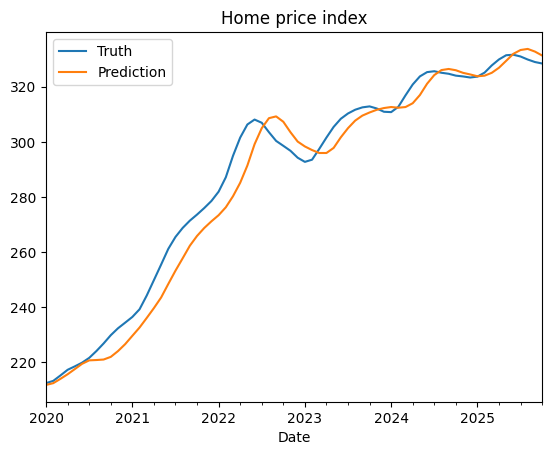

In [ ]:
# Plot the evolution of the true and predicted
# home price indices (over the recent past).
axis = hpi.loc[
    hpi.index >= pd.Period("2020-01", freq="M"),
    ["trueValue", "predictedValue"]
].plot(legend=False, title="Home price index", xlabel="Date")
axis.legend(["Truth",  "Prediction"])
# Note: the home price index is normalized so that
# it is equal to 100 in January 2000.